### RQ 2: Can we identify patterns in the prompts developers use when interacting with ChatGPT, and do these patterns correlate with the success of issue resolution?

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Paths to JSON files containing Hacker News discussions and issue tracking data
hacker_news_json_path = "hack_news.json"
issues_json_path = "issue.json"

# Load and normalize the Hacker News JSON file
data_hacker_news = pd.read_json(hacker_news_json_path)
df_hacker_news = pd.json_normalize(data_hacker_news["Sources"])

# Function to extract prompts from ChatGPT-sharing conversations
def extract_prompts(chatgpt_sharing):
    """Extracts prompt text from ChatGPT-sharing conversations."""
    if not isinstance(chatgpt_sharing, list): 
        return []
    return [conv.get('Prompt', '') for item in chatgpt_sharing for conv in item.get('Conversations', []) if 'Prompt' in conv]

# Extract prompts and remove empty values
df_hacker_news["Prompts"] = df_hacker_news["ChatgptSharing"].apply(extract_prompts)
df_hacker_news = df_hacker_news.explode("Prompts").dropna(subset=["Prompts"])

# Convert prompt text into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_hacker_news["Prompts"])

# Apply K-Means clustering to group similar prompts into five categories
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_hacker_news["PromptCluster"] = kmeans.fit_predict(X)

# Display sample prompts for each cluster to understand their characteristics
pd.set_option('display.max_colwidth', None)
for cluster_id, cluster_df in df_hacker_news.groupby("PromptCluster"):
    print(f"Sample Prompts for Cluster {cluster_id}:")
    print(cluster_df["Prompts"].head(5))
    print()

Sample Prompts for Cluster 0:
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [2]:
# Assign meaningful labels to clusters for easier interpretation
manual_cluster_names = {
    0: "Creative and Writing Requests",
    1: "Repetitive Text Requests",
    2: "File and Code Requests",
    3: "Numeric and Fact-Based Requests",
    4: "Programming and Debugging Requests"
}
df_hacker_news["PromptCluster"] = df_hacker_news["PromptCluster"].map(manual_cluster_names)

# Function to extract ChatGPT interaction URLs from the dataset
def extract_urls(chatgpt_sharing):
    """Extracts URLs from ChatGPT-sharing data."""
    if not isinstance(chatgpt_sharing, list):
        return []
    return [item.get("URL", "") for item in chatgpt_sharing if "URL" in item]

# Extract URLs from ChatGPT interactions in both datasets
df_hacker_news["ChatgptURLs"] = df_hacker_news["ChatgptSharing"].apply(extract_urls)
data_issues = pd.read_json(issues_json_path)
df_issues = pd.json_normalize(data_issues["Sources"])
df_issues["ChatgptURLs"] = df_issues["ChatgptSharing"].apply(extract_urls)

# Flatten extracted URLs by exploding lists and remove empty values
df_hacker_news = df_hacker_news.explode("ChatgptURLs").dropna(subset=["ChatgptURLs"])
df_issues = df_issues.explode("ChatgptURLs").dropna(subset=["ChatgptURLs"])

# Merge datasets using ChatGPT URLs to link prompts with issue resolution status
df_combined = pd.merge(
    df_hacker_news,
    df_issues,
    left_on="ChatgptURLs",
    right_on="ChatgptURLs",
    how="inner"
)

# Create a 'Resolved' column (True if issue state is "CLOSED", False otherwise)
df_combined["Resolved"] = df_combined["State"] == "CLOSED"

# Compute average prompt length per cluster
df_combined["PromptLength"] = df_combined["Prompts"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
avg_prompt_length = df_combined.groupby("PromptCluster")["PromptLength"].mean()

# Compute correlation between prompt patterns and resolution success
correlation = df_combined.groupby("PromptCluster")["Resolved"].mean()

# Function to analyze prompt complexity (word count, unique words, sentence count)
def prompt_complexity_metrics(prompt):
    """Computes word count, unique word count, and sentence count for a given prompt."""
    words = prompt.split()
    num_sentences = prompt.count('.') + prompt.count('!') + prompt.count('?')
    return len(words), len(set(words)), num_sentences

# Apply complexity analysis to prompts
complexity_metrics = df_combined["Prompts"].dropna().apply(prompt_complexity_metrics)
complexity_df = pd.DataFrame(complexity_metrics.tolist(), columns=["WordCount", "UniqueWords", "SentenceCount"], index=df_combined["Prompts"].dropna().index)

# Merge complexity metrics into the main DataFrame
df_combined = pd.concat([df_combined, complexity_df], axis=1)

# Compute average complexity metrics for successful vs. unsuccessful prompts
success_metrics = df_combined[df_combined["Resolved"] == True][["WordCount", "UniqueWords", "SentenceCount"]].mean()
failure_metrics = df_combined[df_combined["Resolved"] == False][["WordCount", "UniqueWords", "SentenceCount"]].mean()

# Compute the number of unique prompts per cluster
unique_prompts_per_cluster = df_combined.groupby("PromptCluster")["Prompts"].nunique()

# Perform keyword frequency analysis for successful and unsuccessful prompts
successful_prompts = df_combined[df_combined["Resolved"] == True]["Prompts"]
unsuccessful_prompts = df_combined[df_combined["Resolved"] == False]["Prompts"]

# Tokenize and count top keywords for each category
def get_top_keywords(prompts, top_n=10):
    """Extracts the most common keywords from a list of prompts."""
    words = [word for prompt in prompts.dropna() for word in prompt.split()]
    return Counter(words).most_common(top_n)

top_successful_keywords = get_top_keywords(successful_prompts)
top_unsuccessful_keywords = get_top_keywords(unsuccessful_prompts)

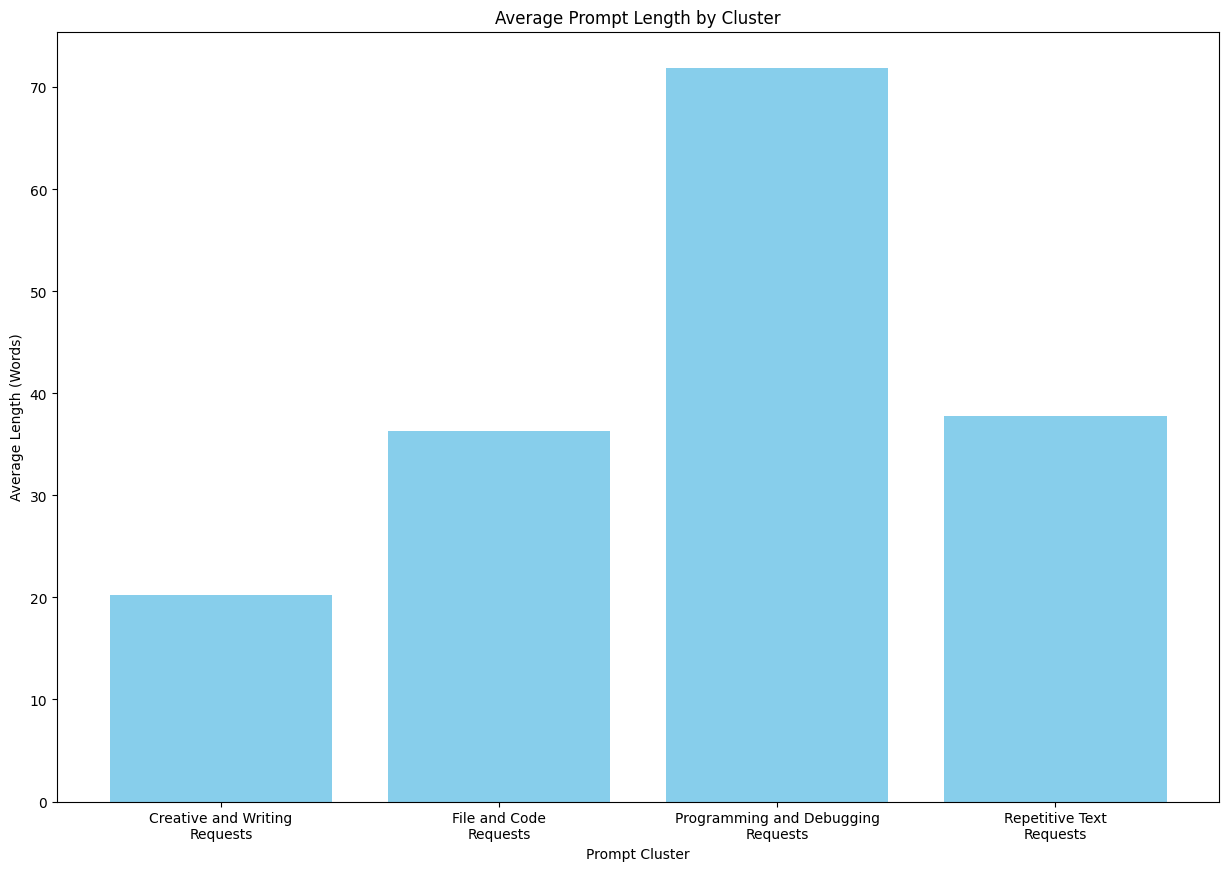

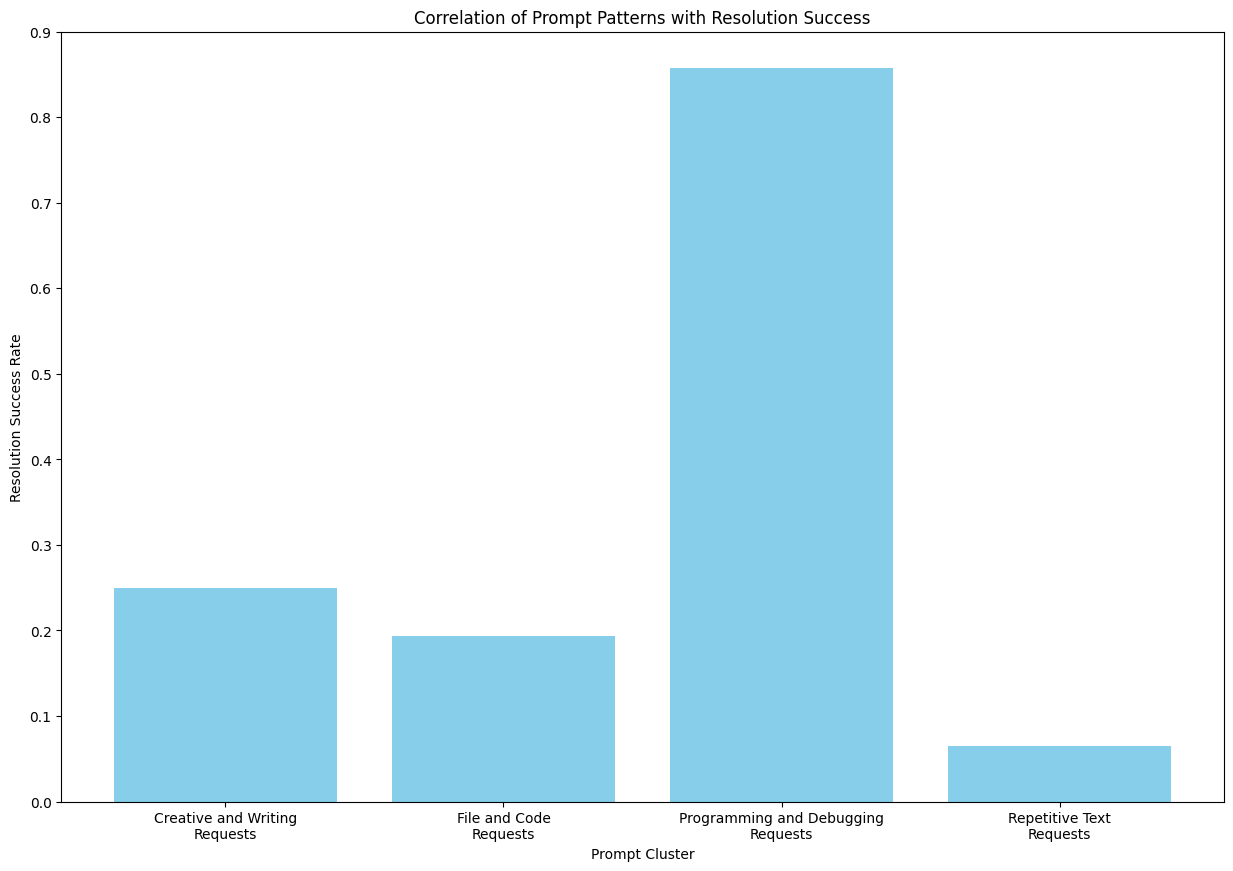

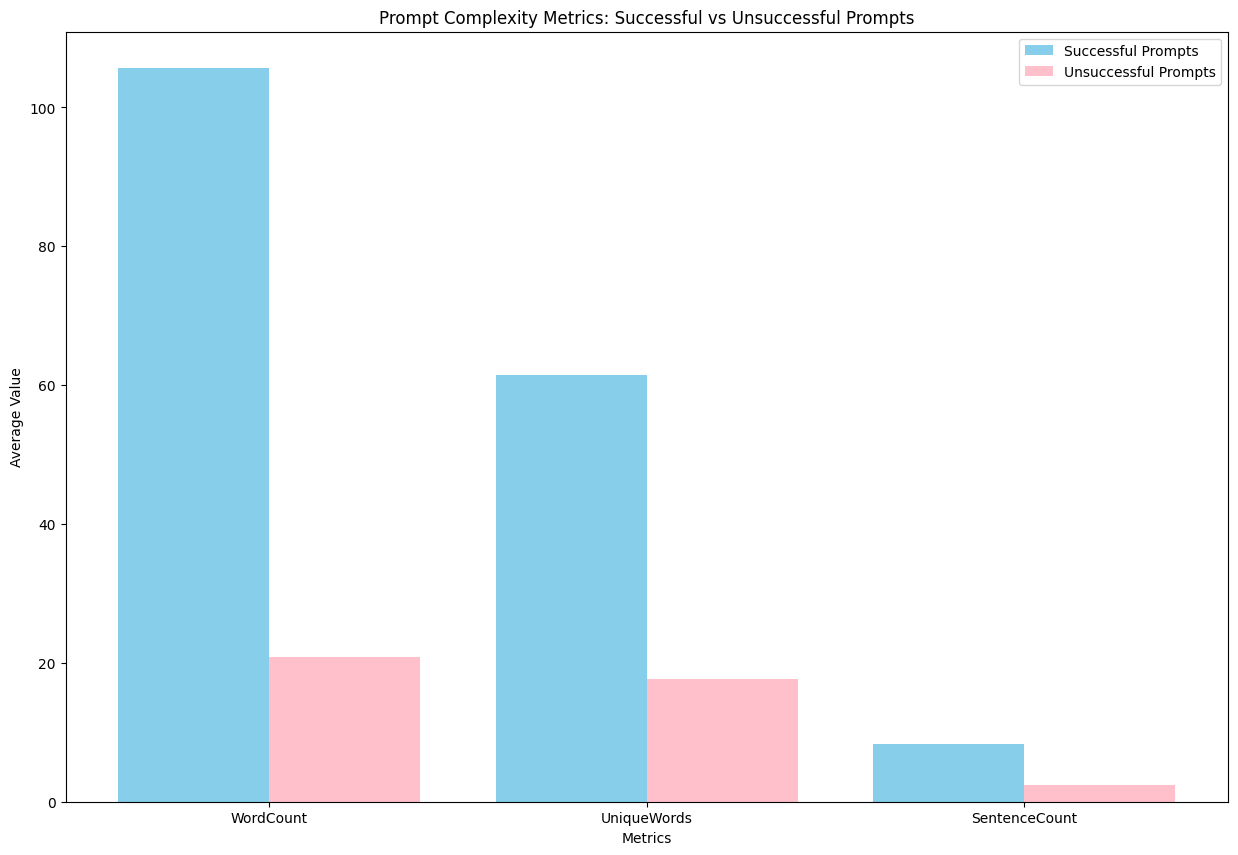

In [3]:
# Modify labels for better visualization
custom_labels = {
    "Creative and Writing Requests": "Creative and Writing\nRequests",
    "Repetitive Text Requests": "Repetitive Text\nRequests",
    "File and Code Requests": "File and Code\nRequests",
    "Numeric and Fact-Based Requests": "Numeric and Fact-Based\nRequests",
    "Programming and Debugging Requests": "Programming and Debugging\nRequests"
}

# Update indices with custom labels
avg_prompt_length.index = avg_prompt_length.index.map(custom_labels)
correlation.index = correlation.index.map(custom_labels)

# Visualization: Average Prompt Length by Cluster
plt.figure(figsize=(15, 10))
plt.bar(avg_prompt_length.index, avg_prompt_length.values, color='skyblue')
plt.title("Average Prompt Length by Cluster")
plt.xlabel("Prompt Cluster")
plt.ylabel("Average Length (Words)")
plt.xticks(rotation=0)
#plt.savefig('Length.jpg', format='jpg', dpi=300)
plt.show()

# Visualization: Correlation of Prompt Patterns with Resolution Success
plt.figure(figsize=(15, 10))
plt.bar(correlation.index, correlation.values, color='skyblue')
plt.title("Correlation of Prompt Patterns with Resolution Success")
plt.xlabel("Prompt Cluster")
plt.ylabel("Resolution Success Rate")
plt.xticks(rotation=0)
#plt.savefig('Correlation.jpg', format='jpg', dpi=300)
plt.show()

# Visualization: Prompt Complexity Metrics Comparison
metrics = ['WordCount', 'UniqueWords', 'SentenceCount']
x = np.arange(len(metrics))

plt.figure(figsize=(15, 10))
plt.bar(x - 0.2, success_metrics.values, 0.4, label='Successful Prompts', color='skyblue')
plt.bar(x + 0.2, failure_metrics.values, 0.4, label='Unsuccessful Prompts', color='pink')
plt.xticks(x, metrics)
plt.title("Prompt Complexity Metrics: Successful vs Unsuccessful Prompts")
plt.xlabel("Metrics")
plt.ylabel("Average Value")
plt.legend()
#plt.savefig('Complexity.jpg', format='jpg', dpi=300)
plt.show()